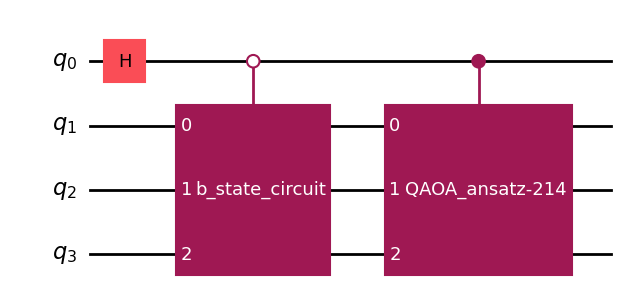

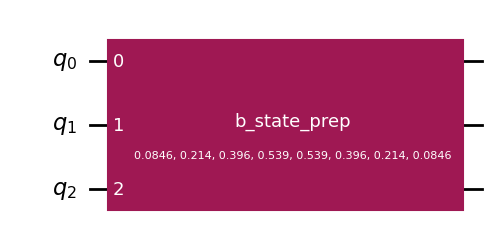

In [3]:
from create_b_state import get_b_statevector

b = get_b_statevector(3)
b[0].draw('mpl')

## < b | A | psi >

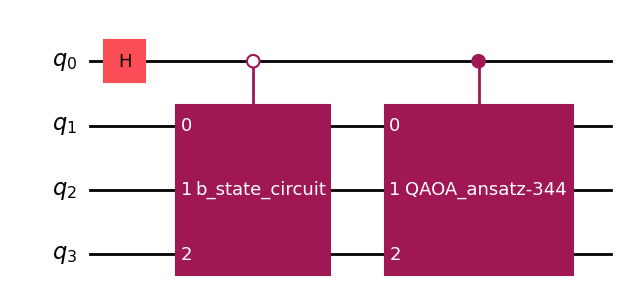

In [4]:
# -*- coding: utf-8 -*-
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator as Estimator  # Aer 대신 기본 Estimator 사용
from qiskit.circuit.library import RYGate
from create_b_state import get_b_statevector
from Ansatz import create_qaoa_ansatz as create_ansatz


ansatz = create_ansatz(3, 1)  # 예시로 3개의 큐빗과 1개의 레이어를 갖는 QAOA 안사츠 생성 -> 파라미터는 2개
b_state = get_b_statevector(3)[0]  # 예시로 3개의 큐빗에 대한 |b⟩ 상태 벡터를 가져옴

# --- 핵심 구현 함수 (Core Implementation Functions) ---

def create_b_psi_circuit(
    b_circuit: QuantumCircuit,
    psi_ansatz: QuantumCircuit,
    theta_value: list[float]
) -> QuantumCircuit:
    """
    이미지 속 수식 |b, ψ(θ)⟩ = (1/√2)[|0⟩|b⟩ + |1⟩|ψ(θ)⟩] 상태를
    생성하는 양자 회로를 구현합니다.

    Args:
        b_circuit (QuantumCircuit): |b⟩ 상태를 만드는 회로 (U_b).
        psi_ansatz (QuantumCircuit): |ψ(θ)⟩ 상태를 만드는 파라미터화된 회로 (U_ψ).
        theta_value (float): 안사츠에 할당할 파라미터 값.

    Returns:
        QuantumCircuit: 최종 중첩 상태를 생성하는 회로.
    """
    num_main_qubits = b_circuit.num_qubits
    
    # 1개의 보조 큐빗(ancilla)과 n개의 주 큐빗(main)으로 구성된 회로 생성
    final_circuit = QuantumCircuit(num_main_qubits + 1)
    main_qubits = list(range(1, num_main_qubits + 1))
    ancilla_qubit = 0

    # 1. 보조 큐빗에 Hadamard 게이트를 적용하여 |+⟩ 상태로 만듭니다.
    final_circuit.h(ancilla_qubit)
    #final_circuit.s(ancilla_qubit)  # S 게이트를 추가하여 |+⟩ 상태를 |0⟩ + i|1⟩로 변환

    # 2. 제어된 U_b 연산을 적용합니다.
    controlled_Ub = b_circuit.to_gate().control(1, ctrl_state=0)
    final_circuit.append(controlled_Ub, [ancilla_qubit] + main_qubits)

    # 3. 제어된 U_ψ 연산을 적용합니다.
    psi_circuit = psi_ansatz.assign_parameters(theta_value)
    controlled_Upsi = psi_circuit.to_gate().control(1, ctrl_state=1)
    final_circuit.append(controlled_Upsi, [ancilla_qubit] + main_qubits)

    return final_circuit


ans = create_b_psi_circuit(
    b_circuit= b_state,
    psi_ansatz=ansatz,
    theta_value= [0.1, 0.2]
    ) 

ans.draw('mpl')

## < psi | A | psi > 용

In [13]:
from Ansatz import create_qaoa_ansatz as create_ansatz

ans = create_ansatz(3, 1)

### Real part

In [14]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit.primitives import StatevectorEstimator as Estimator

def string_to_op(op_str: str) -> Operator:
    """I, +, - 문자열을 Qiskit Operator 객체로 변환합니다."""
    # σ+ = (X + iY)/2, σ- = (X - iY)/2
    # 이 정의는 더 안정적이며 부동 소수점 오류를 줄여줍니다.
    X = Operator.from_label('X')
    Y = Operator.from_label('Y')
    I = Operator.from_label('I')
    
    op_map = {
        'I': I,
        '+': 0.5 * (X + 1j * Y), # Operator([[0, 1], [0, 0]])
        '-': 0.5 * (X - 1j * Y)  # Operator([[0, 0], [1, 0]])
    }
    
    num_qubits = len(op_str)
    if num_qubits == 0:
        return Operator(np.array([[1]]))

    total_op = op_map[op_str[0]]
    for char in op_str[1:]:
        total_op = total_op.tensor(op_map[char])
            
    return total_op

def get_hermitian_observable(op_str: str) -> SparsePauliOp:
    """
    비-에르미트 연산자 문자열 P에 대해 측정 가능한 에르미트 연산자 O를 생성합니다.
    O = X ⊗ Re(P) + Y ⊗ Im(P)
    """
    num_qubits = len(op_str)
    P = string_to_op(op_str)
    P_dag = P.adjoint()
    
    Re_P = 0.5 * (P + P_dag)
    Im_P = -0.5j * (P - P_dag)
    
    # SparsePauliOp으로 변환
    X_op = SparsePauliOp('X')
    Y_op = SparsePauliOp('Y')
    
    Re_P_pauli = SparsePauliOp.from_operator(Re_P)
    Im_P_pauli = SparsePauliOp.from_operator(Im_P)
    
    observable = X_op.tensor(Re_P_pauli) + Y_op.tensor(Im_P_pauli)
    return observable

def measure_non_hermitian_expectation(
    op_str: str,
    ansatz: QuantumCircuit,
    theta: list[float],
    estimator: Estimator
) -> complex:
    """
    논문의 부록 C 방식에 따라 비-에르미트 연산자의 기댓값을 측정합니다.
    """
    num_qubits = len(op_str)
    observable = get_hermitian_observable(op_str) # 논문에서 정의한 에르미트 연산자
    # I, sigma+, sigma-를 Pauli 연산자로 QC가 측정할 수 있게 파울리 연산자로 변환
    
    # --- 실수부 측정을 위한 상태 준비 ---
    # < 0, 1 | < ψ | O | 0, 1 > | ψ >
    real_prep_circuit = QuantumCircuit(num_qubits + 1) # ancilla 큐빗추가 # 아직 비어있음
    main_qubits = list(range(1, num_qubits + 1))
    ancilla_qubit = 0 # ancilla 큐빗 지정

    
    real_prep_circuit.h(ancilla_qubit) # Hadamard 게이트로 상태 준비
    real_prep_circuit.compose(ansatz.assign_parameters(theta), qubits=main_qubits, inplace=True)
    
    # --- 허수부 측정을 위한 상태 준비 ---
    # < 0, j1 |< ψ | O | 0, j1 >| ψ >
    imag_prep_circuit = QuantumCircuit(num_qubits + 1) # ancilla 큐빗 추가하여 빈 회로 생성
    imag_prep_circuit.h(ancilla_qubit) # Hadamard 게이트로 상태 준비
    imag_prep_circuit.s(ancilla_qubit) # 허수부 측정을 위해 S 게이트 추가
    imag_prep_circuit.compose(ansatz.assign_parameters(theta), qubits=main_qubits, inplace=True)
    
    job_real = estimator.run([(real_prep_circuit, [observable], [[]])])
    job_imag = estimator.run([(imag_prep_circuit, [observable], [[]])])
    
    exp_val_real = job_real.result()[0].data.evs[0]
    exp_val_imag = job_imag.result()[0].data.evs[0]
    
    # < 0, 1 | < ψ | O | 0, 1 > | ψ > - j < 0, j1 | < ψ | O | 0, j1 > | ψ >
    return exp_val_real - 1j * exp_val_imag

In [15]:
a = measure_non_hermitian_expectation(
    op_str='-++',
    ansatz=ans,
    theta=[0.1, 0.2],
    estimator=Estimator()
)

print(a)


(0.12425182278469593+0j)


In [16]:
# -*- coding: utf-8 -*-
import numpy as np
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit

def create_hermitian_observable_from_string(op_str: str) -> Operator:
    """
    'I', '+', '-' 문자로 구성된 문자열을 입력받아, 논문에 기술된 방식에 따라
    측정 가능한 에르미트 관측량(Hermitian observable) O를 생성합니다.

    Args:
        op_str (str): 'I', '+', '-'로 구성된 문자열 (예: 'I+-').

    Returns:
        Operator: Qiskit의 Operator 객체로 표현된 최종 관측량 O.
    """
    num_qubits = len(op_str)
    if num_qubits == 0:
        raise ValueError("입력 문자열은 비어 있을 수 없습니다.")

    # --- 1단계: 기본 연산자 정의 ---
    # I = 항등 연산자, p = 상승 연산자(σ+), m = 하강 연산자(σ-)
    op_map = {
        'I': Operator(np.array([[1, 0], [0, 1]], dtype=complex)),
        '+': Operator(np.array([[0, 1], [0, 0]], dtype=complex)),
        '-': Operator(np.array([[0, 0], [1, 0]], dtype=complex))
    }

    # --- 2단계: 문자열로부터 비-에르미트 연산자 P 생성 ---
    # 문자열의 각 문자에 해당하는 연산자를 텐서곱(tensor product)합니다.
    # 예: 'I+-' -> I ⊗ σ+ ⊗ σ-
    P = op_map[op_str[0]]
    for char in op_str[1:]:
        P = P.tensor(op_map[char])

    # --- 3단계: P를 이용하여 에르미트 관측량 O 생성 ---
    # O = [[0, P†], [P, 0]] 형태의 블록 행렬을 만듭니다.
    P_dag = P.adjoint()
    dim = 2**num_qubits

    # (2*dim x 2*dim) 크기의 0 행렬 생성
    O_matrix = np.zeros((2 * dim, 2 * dim), dtype=complex)

    # P를 오른쪽 아래 블록에, P†를 왼쪽 위 블록에 배치
    O_matrix[dim:, :dim] = P.to_matrix()
    O_matrix[:dim, dim:] = P_dag.to_matrix()

    # 최종 행렬을 Qiskit Operator 객체로 변환하여 반환
    return Operator(O_matrix)

# --- 예제 실행 (Example Usage) ---
if __name__ == '__main__':
    # 테스트할 연산자 문자열
    test_op_string = 'I+-'
    
    print(f"입력 문자열 P = '{test_op_string}'")
    
    # 함수를 호출하여 관측량 O 생성
    observable_O = create_hermitian_observable_from_string(test_op_string)
    
    print(f"\n생성된 관측량 O의 차원: {observable_O.dim}")
    print(f"작용하는 큐빗 수: {observable_O.num_qubits}")
    
    # 생성된 연산자가 에르미트인지 확인 (O == O†)
    is_hermitian = observable_O == observable_O.adjoint()
    print(f"생성된 연산자는 에르미트(Hermitian)입니까? -> {is_hermitian}")
    
    # 생성된 행렬을 소수점 3자리까지 출력하여 확인
    print("\n생성된 관측량 O의 행렬 표현 (반올림):")
    print(np.round(observable_O.to_matrix(), 3))

    # --- 단일 큐빗 예제 (논문 O_12와 비교) ---
    print("\n" + "="*40)
    test_op_single = '-'
    print(f"단일 큐빗 예제: P = '{test_op_single}' (σ-)")
    observable_O12 = create_hermitian_observable_from_string(test_op_single)
    print("\n생성된 O_12 행렬:")
    print(observable_O12.to_matrix())
    # 예상 결과: [[0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 0]]

입력 문자열 P = 'I+-'

생성된 관측량 O의 차원: (16, 16)
작용하는 큐빗 수: 4
생성된 연산자는 에르미트(Hermitian)입니까? -> True

생성된 관측량 O의 행렬 표현 (반올림):
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-0.j 0.-0.j
  0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-0.j 0.-0.j
  0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-0.j 1.-0.j
  0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-0.j 0.-0.j
  0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-0.j 0.-0.j
  0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-0.j 0.-0.j
  0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j 0.-0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-0.j 0.-0.j
  0.-0.j 0.-0.j 0.-0.j 1.-0.j 0.-0.j 0.-0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-0.j

In [17]:
# -*- coding: utf-8 -*-
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.circuit.library import RYGate

# --- 헬퍼 함수 (Helper Functions) ---

def string_to_op(op_str: str) -> Operator:
    """I, +, - 문자열을 Qiskit Operator 객체로 변환합니다."""
    X = Operator.from_label('X')
    Y = Operator.from_label('Y')
    I = Operator.from_label('I')
    op_map = {
        'I': I,
        '+': 0.5 * (X + 1j * Y),
        '-': 0.5 * (X - 1j * Y)
    }
    num_qubits = len(op_str)
    if num_qubits == 0: return Operator(np.array([[1]]))
    total_op = op_map[op_str[0]]
    for char in op_str[1:]:
        total_op = total_op.tensor(op_map[char])
    return total_op

def get_hermitian_observable(op_str: str) -> SparsePauliOp:
    """
    비-에르미트 연산자 문자열 P에 대해 측정 가능한 에르미트 관측량 O를 생성합니다.
    O = X ⊗ Re(P) + Y ⊗ Im(P)
    """
    P = string_to_op(op_str)
    P_dag = P.adjoint()
    Re_P = 0.5 * (P + P_dag)
    Im_P = -0.5j * (P - P_dag)
    
    X_op = SparsePauliOp('X')
    Y_op = SparsePauliOp('Y')
    
    Re_P_pauli = SparsePauliOp.from_operator(Re_P)
    Im_P_pauli = SparsePauliOp.from_operator(Im_P)
    
    observable = X_op.tensor(Re_P_pauli) + Y_op.tensor(Im_P_pauli)
    return observable


def create_b_psi_circuit(b_circuit, psi_ansatz, theta_value):
    num_main_qubits = b_circuit.num_qubits
    final_circuit = QuantumCircuit(num_main_qubits + 1)
    main_qubits = list(range(1, num_main_qubits + 1))
    ancilla_qubit = 0
    final_circuit.h(ancilla_qubit)
    controlled_Ub = b_circuit.decompose().to_gate().control(1, ctrl_state=0)
    final_circuit.append(controlled_Ub, [ancilla_qubit] + main_qubits)
    psi_circuit = psi_ansatz.assign_parameters(theta_value)
    controlled_Upsi = psi_circuit.decompose().to_gate().control(1, ctrl_state=1)
    final_circuit.append(controlled_Upsi, [ancilla_qubit] + main_qubits)
    return final_circuit

def calculate_expectation_value(state_circuit, observable):
    estimator = Estimator()
    job = estimator.run([(state_circuit, [observable], [[]])])
    result = job.result()
    return result[0].data.evs[0]

# --- 예제 실행 (Example Usage) ---
if __name__ == '__main__':
    # 측정하려는 비-에르미트 연산자 P 정의
    p_term_str = 'I+-'
    num_qubits = len(p_term_str)
    
    # 안사츠에 적용할 예제 파라미터 값
    theta_params = [np.pi / 2, np.pi / 4]  # 예시로 3개의 파라미터 사용

    # 1. |b⟩와 |ψ(θ)⟩를 만드는 회로 준비
    ansatz = create_ansatz(3, 1)  # 예시로 3개의 큐빗과 1개의 레이어를 갖는 QAOA 안사츠 생성 -> 파라미터는 2개
    b_state = get_b_statevector(3)[0]  # 예시로 3개의 큐빗에 대한 |b⟩ 상태 벡터를 가져옴
    Ub_circuit = b_state  # 예제용 |b⟩ 상태를 만드는 유니타리 회로
    #get_b_preparation_circuit(num_qubits)
    Upsi_ansatz = ansatz  # 예제용 |ψ(θ)⟩ 상태를 만드는 파라미터화된 회로
    #get_psi_ansatz(num_qubits) 

    # 2. |b, ψ(θ)⟩ 상태를 만드는 최종 회로 생성
    b_psi_superposition_circuit = create_b_psi_circuit(Ub_circuit, Upsi_ansatz, theta_params)
    
    # ############################################################# #
    # ########           요청하신 수정 부분입니다           ######## #
    # ############################################################# #
    # 3. p_term으로부터 측정 가능한 관측량 O 생성
    example_observable = get_hermitian_observable(p_term_str)
    
    print(f"--- P = '{p_term_str}'에 대한 기댓값 계산 ---")
    print(f"생성된 관측량 O:\n{example_observable}")
    print("-" * 30)

    # 4. 생성된 상태에 대한 기댓값 계산
    # 이 값은 Re(<b|P|ψ>)와 같습니다.
    exp_val = calculate_expectation_value(b_psi_superposition_circuit, example_observable)
    exp_val = np.abs(exp_val)**2
    
    print(f"측정된 기댓값 ⟨b,ψ|O|b,ψ⟩: {exp_val:.4f}")
    print("-" * 30)
    
    # 5. 이론적인 값과 비교 (검증용)
    b_state = Statevector(Ub_circuit)
    psi_state = Statevector(Upsi_ansatz.assign_parameters(theta_params))
    
    P_op = string_to_op(p_term_str)
    
    # Re(<b|P|ψ>) 계산
    # !!!!! 수정된 부분: Statevector.adjoint() 대신 inner()와 evolve() 사용 !!!!!
    theoretical_exp_val = np.abs(np.real(b_state.inner(psi_state.evolve(P_op))))**2
    
    print(f"이론적인 Re(⟨b|P|ψ⟩) 값 (검증용): {theoretical_exp_val:.4f}")


--- P = 'I+-'에 대한 기댓값 계산 ---
생성된 관측량 O:
SparsePauliOp(['XIXX', 'XIYY', 'YIXY', 'YIYX'],
              coeffs=[ 0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j])
------------------------------
측정된 기댓값 ⟨b,ψ|O|b,ψ⟩: 0.0066
------------------------------
이론적인 Re(⟨b|P|ψ⟩) 값 (검증용): 0.0232


In [18]:
# -*- coding: utf-8 -*-
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit.primitives import StatevectorEstimator as Estimator

# --- 헬퍼 함수 (이전 코드에서 가져옴) ---

def string_to_op(op_str: str) -> Operator:
    """I, +, - 문자열을 Qiskit Operator 객체로 변환합니다."""
    X = Operator.from_label('X')
    Y = Operator.from_label('Y')
    I = Operator.from_label('I')
    
    op_map = {
        'I': I,
        '+': 0.5 * (X + 1j * Y),
        '-': 0.5 * (X - 1j * Y)
    }
    
    num_qubits = len(op_str)
    if num_qubits == 0: return Operator(np.array([[1]]))

    total_op = op_map[op_str[0]]
    for char in op_str[1:]:
        total_op = total_op.tensor(op_map[char])
            
    return total_op

def get_hermitian_observable(op_str: str) -> SparsePauliOp:
    """비-에르미트 연산자 P에 대해 측정 가능한 에르미트 관측량 O를 생성합니다."""
    P = string_to_op(op_str)
    P_dag = P.adjoint()
    Re_P = 0.5 * (P + P_dag)
    Im_P = -0.5j * (P - P_dag)
    
    X_op = SparsePauliOp('X')
    Y_op = SparsePauliOp('Y')
    
    Re_P_pauli = SparsePauliOp.from_operator(Re_P)
    Im_P_pauli = SparsePauliOp.from_operator(Im_P)
    
    observable = X_op.tensor(Re_P_pauli) + Y_op.tensor(Im_P_pauli)
    return observable

def get_b_preparation_circuit(num_qubits: int) -> QuantumCircuit:
    """예제용 |b⟩ 상태 (|...+⟩)를 만드는 유니타리 회로를 반환합니다."""
    b_circuit = QuantumCircuit(num_qubits, name="U_b")
    b_circuit.h(range(num_qubits))
    return b_circuit

def get_psi_ansatz(num_qubits: int) -> QuantumCircuit:
    """예제용 안사츠 |ψ(θ)⟩를 만드는 회로를 반환합니다."""
    from qiskit.circuit import Parameter
    psi_circuit = QuantumCircuit(num_qubits, name="U_ψ")
    for i in range(num_qubits):
        theta = Parameter(f'θ{i}')
        psi_circuit.ry(theta, i)
    return psi_circuit

# --- 제공된 함수 (사용자 코드, 오류 수정됨) ---

def create_real_b_psi_circuit(b_circuit, psi_ansatz, theta_value):
    num_main_qubits = b_circuit.num_qubits
    final_circuit = QuantumCircuit(num_main_qubits + 1)
    main_qubits = list(range(1, num_main_qubits + 1))
    ancilla_qubit = 0
    final_circuit.h(ancilla_qubit)
    
    # .decompose()를 사용하여 회로를 기본 게이트로 분해 (initialize, barrier 등 제거)
    controlled_Ub = b_circuit.decompose().to_gate().control(1, ctrl_state=0)
    final_circuit.append(controlled_Ub, [ancilla_qubit] + main_qubits)

    psi_circuit_with_params = psi_ansatz.assign_parameters(theta_value)
    controlled_Upsi = psi_circuit_with_params.decompose().to_gate().control(1, ctrl_state=1)
    final_circuit.append(controlled_Upsi, [ancilla_qubit] + main_qubits)
    return final_circuit

def create_imag_b_psi_circuit(b_circuit, psi_ansatz, theta_value):
    num_main_qubits = b_circuit.num_qubits
    final_circuit = QuantumCircuit(num_main_qubits + 1)
    main_qubits = list(range(1, num_main_qubits + 1))
    ancilla_qubit = 0
    final_circuit.h(ancilla_qubit)
    final_circuit.s(ancilla_qubit) # 허수부 측정을 위해 S 게이트 추가
    
    controlled_Ub = b_circuit.decompose().to_gate().control(1, ctrl_state=0)
    final_circuit.append(controlled_Ub, [ancilla_qubit] + main_qubits)

    psi_circuit_with_params = psi_ansatz.assign_parameters(theta_value)
    controlled_Upsi = psi_circuit_with_params.decompose().to_gate().control(1, ctrl_state=1)
    final_circuit.append(controlled_Upsi, [ancilla_qubit] + main_qubits)
    return final_circuit

# ############################################################# #
# ########        요청하신 핵심 함수입니다        ######## #
# ############################################################# #
def calculate_b_P_psi_squared(
    p_term: str,
    b_circuit: QuantumCircuit,
    psi_ansatz: QuantumCircuit,
    theta_value: list[float]
) -> float:
    """
    Hadamard-like 측정을 사용하여 |<b|P|ψ>|² 값을 계산합니다.

    Args:
        p_term (str): 측정할 연산자 문자열 (예: 'I+-').
        b_circuit (QuantumCircuit): |b⟩ 상태를 만드는 회로.
        psi_ansatz (QuantumCircuit): |ψ(θ)⟩ 상태를 만드는 파라미터화된 회로.
        theta_value (list[float]): 안사츠에 할당할 파라미터 값.

    Returns:
        float: 계산된 |<b|P|ψ>|² 값.
    """
    estimator = Estimator()
    
    # 1. 측정 가능한 에르미트 관측량 O 생성
    observable = get_hermitian_observable(p_term)

    # 2. 실수부 측정을 위한 상태 준비 및 기댓값 계산
    real_state_circuit = create_real_b_psi_circuit(b_circuit, psi_ansatz, theta_value)
    job_real = estimator.run([(real_state_circuit, [observable], [[]])])
    real_part = job_real.result()[0].data.evs[0]

    # 3. 허수부 측정을 위한 상태 준비 및 기댓값 계산
    imag_state_circuit = create_imag_b_psi_circuit(b_circuit, psi_ansatz, theta_value)
    job_imag = estimator.run([(imag_state_circuit, [observable], [[]])])
    imag_part = job_imag.result()[0].data.evs[0]
    
    # 4. 최종 값 |<b|P|ψ>|² 계산
    # 이론에 따라, Im(<b|P|ψ>) = <O>_{imag_prep} 입니다.
    magnitude_squared = real_part**2 + imag_part**2

    print(f"--- Calculation for P = '{p_term}' ---")
    print(f"  Re(<b|P|ψ>) ≈ {real_part:.4f}")
    print(f"  Im(<b|P|ψ>) ≈ {imag_part:.4f}")
    print(f"  |<b|P|ψ>|² ≈ {magnitude_squared:.4f}")
    
    return magnitude_squared

# --- 예제 실행 (Example Usage) ---
if __name__ == '__main__':
    num_qubits = 3
    
    # 예제에 사용할 회로와 파라미터 준비
    b_prep_circuit = get_b_preparation_circuit(num_qubits)
    psi_ansatz_circuit = get_psi_ansatz(num_qubits)
    theta_params = [np.pi/2, np.pi/4, np.pi/8]
    
    # 'I+-' 항에 대한 |<b|P|ψ>|² 값 계산
    result = calculate_b_P_psi_squared(
        p_term='I+-',
        b_circuit=b_prep_circuit,
        psi_ansatz=psi_ansatz_circuit,
        theta_value=theta_params
    )


--- Calculation for P = 'I+-' ---
  Re(<b|P|ψ>) ≈ 0.0637
  Im(<b|P|ψ>) ≈ 0.0000
  |<b|P|ψ>|² ≈ 0.0041


In [19]:
# -*- coding: utf-8 -*-
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit.primitives import StatevectorEstimator as Estimator

# --- 헬퍼 함수 (이전 코드에서 가져옴) ---

def string_to_op(op_str: str) -> Operator:
    """I, +, - 문자열을 Qiskit Operator 객체로 변환합니다."""
    X = Operator.from_label('X')
    Y = Operator.from_label('Y')
    I = Operator.from_label('I')
    
    op_map = {
        'I': I,
        '+': 0.5 * (X + 1j * Y),
        '-': 0.5 * (X - 1j * Y)
    }
    
    num_qubits = len(op_str)
    if num_qubits == 0: return Operator(np.array([[1]]))

    total_op = op_map[op_str[0]]
    for char in op_str[1:]:
        total_op = total_op.tensor(op_map[char])
            
    return total_op

def get_hermitian_observable(op_str: str) -> SparsePauliOp:
    """비-에르미트 연산자 P에 대해 측정 가능한 에르미트 관측량 O를 생성합니다."""
    P = string_to_op(op_str)
    P_dag = P.adjoint()
    Re_P = 0.5 * (P + P_dag)
    Im_P = -0.5j * (P - P_dag)
    
    X_op = SparsePauliOp('X')
    Y_op = SparsePauliOp('Y')
    
    Re_P_pauli = SparsePauliOp.from_operator(Re_P)
    Im_P_pauli = SparsePauliOp.from_operator(Im_P)
    
    observable = X_op.tensor(Re_P_pauli) + Y_op.tensor(Im_P_pauli)
    return observable

def get_b_preparation_circuit(num_qubits: int) -> QuantumCircuit:
    """예제용 |b⟩ 상태 (|...+⟩)를 만드는 유니타리 회로를 반환합니다."""
    b_circuit = QuantumCircuit(num_qubits, name="U_b")
    b_circuit.h(range(num_qubits))
    return b_circuit

def get_psi_ansatz(num_qubits: int) -> QuantumCircuit:
    """예제용 안사츠 |ψ(θ)⟩를 만드는 회로를 반환합니다."""
    from qiskit.circuit import Parameter
    psi_circuit = QuantumCircuit(num_qubits, name="U_ψ")
    for i in range(num_qubits):
        theta = Parameter(f'θ{i}')
        psi_circuit.ry(theta, i)
    return psi_circuit

# --- 제공된 함수 (사용자 코드, 오류 수정됨) ---

def create_real_b_psi_circuit(b_circuit, psi_ansatz, theta_value):
    num_main_qubits = b_circuit.num_qubits
    final_circuit = QuantumCircuit(num_main_qubits + 1)
    main_qubits = list(range(1, num_main_qubits + 1))
    ancilla_qubit = 0
    final_circuit.h(ancilla_qubit)
    
    # .decompose()를 사용하여 회로를 기본 게이트로 분해 (initialize, barrier 등 제거)
    controlled_Ub = b_circuit.decompose().to_gate().control(1, ctrl_state=0)
    final_circuit.append(controlled_Ub, [ancilla_qubit] + main_qubits)

    psi_circuit_with_params = psi_ansatz.assign_parameters(theta_value)
    controlled_Upsi = psi_circuit_with_params.decompose().to_gate().control(1, ctrl_state=1)
    final_circuit.append(controlled_Upsi, [ancilla_qubit] + main_qubits)
    return final_circuit

def create_imag_b_psi_circuit(b_circuit, psi_ansatz, theta_value):
    num_main_qubits = b_circuit.num_qubits
    final_circuit = QuantumCircuit(num_main_qubits + 1)
    main_qubits = list(range(1, num_main_qubits + 1))
    ancilla_qubit = 0
    final_circuit.h(ancilla_qubit)
    final_circuit.s(ancilla_qubit) # 허수부 측정을 위해 S 게이트 추가
    
    controlled_Ub = b_circuit.decompose().to_gate().control(1, ctrl_state=0)
    final_circuit.append(controlled_Ub, [ancilla_qubit] + main_qubits)

    psi_circuit_with_params = psi_ansatz.assign_parameters(theta_value)
    controlled_Upsi = psi_circuit_with_params.decompose().to_gate().control(1, ctrl_state=1)
    final_circuit.append(controlled_Upsi, [ancilla_qubit] + main_qubits)
    return final_circuit

def calculate_b_P_psi_squared(
    p_term: str,
    b_circuit: QuantumCircuit,
    psi_ansatz: QuantumCircuit,
    theta_value: list[float],
    estimator: Estimator
) -> float:
    """
    Hadamard-like 측정을 사용하여 단일 항에 대한 |<b|P|ψ>|² 값을 계산합니다.
    """
    # 1. 측정 가능한 에르미트 관측량 O 생성
    observable = get_hermitian_observable(p_term)

    # 2. 실수부 측정을 위한 상태 준비 및 기댓값 계산
    real_state_circuit = create_real_b_psi_circuit(b_circuit, psi_ansatz, theta_value)
    job_real = estimator.run([(real_state_circuit, [observable], [[]])])
    real_part = job_real.result()[0].data.evs[0]

    # 3. 허수부 측정을 위한 상태 준비 및 기댓값 계산
    imag_state_circuit = create_imag_b_psi_circuit(b_circuit, psi_ansatz, theta_value)
    job_imag = estimator.run([(imag_state_circuit, [observable], [[]])])
    imag_part = job_imag.result()[0].data.evs[0]
    
    # 4. 최종 값 |<b|P|ψ>|² 계산
    magnitude_squared = real_part**2 + imag_part**2

    print(f"  - Term '{p_term}': Re≈{real_part:.4f}, Im≈{imag_part:.4f}, |<·>|²≈{magnitude_squared:.4f}")
    
    return magnitude_squared

# ############################################################# #
# ########        요청하신 추가 함수입니다        ######## #
# ############################################################# #
def calculate_sum_from_dict(
    p_dict: dict,
    b_circuit: QuantumCircuit,
    psi_ansatz: QuantumCircuit,
    theta_value: list[float]
) -> float:
    """
    연산자 딕셔너리를 받아 각 항의 |<b|P_k|ψ>|² 값을 계산하고,
    계수를 곱하여 총합을 반환합니다.

    Args:
        p_dict (dict): {'I+-': coeff1, ...} 형태의 연산자 딕셔너리.
        b_circuit (QuantumCircuit): |b⟩ 상태를 만드는 회로.
        psi_ansatz (QuantumCircuit): |ψ(θ)⟩ 상태를 만드는 파라미터화된 회로.
        theta_value (list[float]): 안사츠에 할당할 파라미터 값.

    Returns:
        float: 계산된 총합 Σ c_k * |<b|P_k|ψ>|².
    """
    total_sum = 0.0
    estimator = Estimator() # Estimator를 한 번만 생성하여 재사용

    print(f"--- Calculating Sum for Dictionary ---")
    
    for p_term, coeff in p_dict.items():
        # 각 항에 대해 |<b|P|ψ>|² 값을 계산
        term_value_sq = calculate_b_P_psi_squared(
            p_term, b_circuit, psi_ansatz, theta_value, estimator
        )
        # 계산된 값에 계수를 곱하여 총합에 더함
        total_sum += coeff * term_value_sq
        
    print(f"------------------------------------")
    print(f"Total Sum = {total_sum:.4f}")
    return total_sum

# --- 예제 실행 (Example Usage) ---
if __name__ == '__main__':
    num_qubits = 3
    
    # 예제에 사용할 회로와 파라미터 준비
    #b_prep_circuit = get_b_preparation_circuit(num_qubits)
    b_prep_circuit = get_b_statevector(num_qubits)[0]  # 예제용 |b⟩ 상태를 만드는 유니타리 회로
    psi_ansatz_circuit = get_psi_ansatz(num_qubits)
    psi_ansatz_circuit = create_ansatz(3, 1)
    theta_params = [np.pi/2, np.pi/4]
    
    # 계산할 연산자 딕셔너리 예제

    from decomposition import decompose_A_matrix

    A = decompose_A_matrix(3)
     
    operator_dict = {
        'I+-': 2.0,
        '--I': -0.5,
        '+++': 1.0
    }
    print(A)

    operator_dict = decompose_A_matrix(3)

    # 딕셔너리에 대한 총합 계산
    result = calculate_sum_from_dict(
        p_dict=operator_dict,
        b_circuit=b_prep_circuit,
        psi_ansatz=psi_ansatz_circuit,
        theta_value=theta_params
    )


{'III': 2.0, 'II+': -1.0, 'II-': -1.0, '-++': -1.0, '+--': -1.0, 'I-+': -1.0, 'I+-': -1.0}
--- Calculating Sum for Dictionary ---


ValueError: need at least one array to concatenate

ModuleNotFoundError: No module named 'qiskit.providers.aer'

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit.primitives import StatevectorEstimator as Estimator
from decomposition import decompose_A_matrix, decompose_B_matrix

# --- 헬퍼 함수 (이전 코드에서 가져옴) ---

def string_to_op(op_str: str) -> Operator:
    """I, +, - 문자열을 Qiskit Operator 객체로 변환합니다."""
    X = Operator.from_label('X')
    Y = Operator.from_label('Y')
    I = Operator.from_label('I')
    
    op_map = {
        'I': I,
        '+': 0.5 * (X + 1j * Y),
        '-': 0.5 * (X - 1j * Y)
    }
    
    num_qubits = len(op_str)
    if num_qubits == 0: return Operator(np.array([[1]]))

    total_op = op_map[op_str[0]]
    for char in op_str[1:]:
        total_op = total_op.tensor(op_map[char])
            
    return total_op

def get_hermitian_observable(op_str: str) -> SparsePauliOp:
    """비-에르미트 연산자 P에 대해 측정 가능한 에르미트 관측량 O를 생성합니다."""
    num_qubits = len(op_str)
    P = string_to_op(op_str)
    P_dag = P.adjoint()
    
    Re_P = 0.5 * (P + P_dag)
    Im_P = -0.5j * (P - P_dag)
    
    X_op = SparsePauliOp('X')
    Y_op = SparsePauliOp('Y')
    
    # Re(P)나 Im(P)가 0 행렬인 경우를 안정적으로 처리합니다.
    if np.allclose(Re_P.to_matrix(), np.zeros_like(Re_P.to_matrix())):
        term1 = SparsePauliOp('I' * (num_qubits + 1), coeffs=[0])
    else:
        Re_P_pauli = SparsePauliOp.from_operator(Re_P)
        term1 = X_op.tensor(Re_P_pauli)

    if np.allclose(Im_P.to_matrix(), np.zeros_like(Im_P.to_matrix())):
        term2 = SparsePauliOp('I' * (num_qubits + 1), coeffs=[0])
    else:
        Im_P_pauli = SparsePauliOp.from_operator(Im_P)
        term2 = Y_op.tensor(Im_P_pauli)
        
    return term1 + term2

def get_b_preparation_circuit(num_qubits: int) -> QuantumCircuit:
    """
    예제용 |b⟩ 상태를 만드는 유니타리 회로를 반환합니다.
    |b⟩ = |+...+⟩ 상태 (모든 큐빗에 H 게이트 적용)
    """
    b_circuit = QuantumCircuit(num_qubits, name="U_b")
    b_circuit.h(range(num_qubits))
    return b_circuit

def get_psi_ansatz(num_qubits: int) -> QuantumCircuit:
    """예제용 안사츠 |ψ(θ)⟩를 만드는 회로를 반환합니다."""
    from qiskit.circuit import Parameter
    psi_circuit = QuantumCircuit(num_qubits, name="U_ψ")
    for i in range(num_qubits):
        theta = Parameter(f'θ{i}')
        psi_circuit.ry(theta, i)
    return psi_circuit

# --- 제공된 함수 (사용자 코드, 오류 수정됨) ---

def create_real_b_psi_circuit(b_circuit, psi_ansatz, theta_value):
    num_main_qubits = b_circuit.num_qubits
    final_circuit = QuantumCircuit(num_main_qubits + 1)
    main_qubits = list(range(1, num_main_qubits + 1))
    ancilla_qubit = 0
    final_circuit.h(ancilla_qubit)
    
    # .decompose()를 사용하여 회로를 기본 게이트로 분해 (initialize, barrier 등 제거)
    controlled_Ub = b_circuit.decompose().to_gate().control(1, ctrl_state=0)
    final_circuit.append(controlled_Ub, [ancilla_qubit] + main_qubits)

    psi_circuit_with_params = psi_ansatz.assign_parameters(theta_value)
    controlled_Upsi = psi_circuit_with_params.decompose().to_gate().control(1, ctrl_state=1)
    final_circuit.append(controlled_Upsi, [ancilla_qubit] + main_qubits)
    return final_circuit

def create_imag_b_psi_circuit(b_circuit, psi_ansatz, theta_value):
    num_main_qubits = b_circuit.num_qubits
    final_circuit = QuantumCircuit(num_main_qubits + 1)
    main_qubits = list(range(1, num_main_qubits + 1))
    ancilla_qubit = 0
    final_circuit.h(ancilla_qubit)
    final_circuit.s(ancilla_qubit) # 허수부 측정을 위해 S 게이트 추가
    
    controlled_Ub = b_circuit.decompose().to_gate().control(1, ctrl_state=0)
    final_circuit.append(controlled_Ub, [ancilla_qubit] + main_qubits)

    psi_circuit_with_params = psi_ansatz.assign_parameters(theta_value)
    controlled_Upsi = psi_circuit_with_params.decompose().to_gate().control(1, ctrl_state=1)
    final_circuit.append(controlled_Upsi, [ancilla_qubit] + main_qubits)
    return final_circuit

# --- 핵심 계산 함수 (수정됨) ---

def calculate_b_P_psi(
    p_term: str,
    b_circuit: QuantumCircuit,
    psi_ansatz: QuantumCircuit,
    theta_value: list[float],
    estimator: Estimator
) -> complex:
    """
    Hadamard-like 측정을 사용하여 단일 항에 대한 복소수 기댓값 <b|P|ψ>를 계산합니다.
    """
    observable = get_hermitian_observable(p_term)

    real_state_circuit = create_real_b_psi_circuit(b_circuit, psi_ansatz, theta_value)
    job_real = estimator.run([(real_state_circuit, [observable], [[]])])
    real_part = job_real.result()[0].data.evs[0]

    imag_state_circuit = create_imag_b_psi_circuit(b_circuit, psi_ansatz, theta_value)
    job_imag = estimator.run([(imag_state_circuit, [observable], [[]])])
    imag_part = job_imag.result()[0].data.evs[0]
    
    # Im(<b|P|ψ>) = <O>_{imag_prep}
    return real_part + 1j * imag_part

def calculate_b_A_psi_squared_from_dict(
    p_dict: dict,
    b_circuit: QuantumCircuit,
    psi_ansatz: QuantumCircuit,
    theta_value: list[float]
) -> float:
    """
    연산자 딕셔너리를 받아 <b|A|ψ> = Σ c_k <b|P_k|ψ>를 계산한 뒤,
    그 크기의 제곱을 반환합니다.
    """
    total_complex_value = 0.0 + 0.0j
    estimator = Estimator()

    print(f"--- Calculating |<b|A|ψ>|² for Dictionary ---")
    
    for p_term, coeff in p_dict.items():
        # 각 항에 대해 복소수 기댓값 <b|P|ψ>를 계산
        complex_exp_val = calculate_b_P_psi(
            p_term, b_circuit, psi_ansatz, theta_value, estimator
        )
        print(f"  - Term '{p_term}': <b|P|ψ> ≈ {complex_exp_val:.4f}")
        
        # 계산된 값에 계수를 곱하여 총합에 더함
        total_complex_value += coeff * complex_exp_val
        
    magnitude_squared = np.abs(total_complex_value)**2
    
    print(f"------------------------------------")
    print(f"Total <b|A|ψ> ≈ {total_complex_value:.4f}")
    print(f"Final |<b|A|ψ>|² = {magnitude_squared:.4f}")
    return magnitude_squared

# --- 예제 실행 (수정됨) ---
if __name__ == '__main__':
    # decomposition.py와 Ansatz.py에서 함수를 가져옵니다.
    from decomposition import decompose_A_matrix, decompose_B_matrix
    from Ansatz import create_qaoa_ansatz
    
    num_qubits = 3
    
    # 예제에 사용할 회로와 파라미터 준비
    b_prep_circuit = get_b_preparation_circuit(num_qubits)
    psi_ansatz_circuit = create_qaoa_ansatz(num_qubits, layers=1) # 2개의 파라미터 필요
    theta_params = [np.pi/2, np.pi/4]
    
    # 계산할 연산자 딕셔너리 예제 (A 행렬)
    #operator_dict = decompose_A_matrix(num_qubits)
    operator_dict = decompose_B_matrix(num_qubits)
    print("Operator Dictionary B:\n", operator_dict)

    # 딕셔너리에 대한 총합 계산
    result = calculate_b_A_psi_squared_from_dict(
        p_dict=operator_dict,
        b_circuit=b_prep_circuit,
        psi_ansatz=psi_ansatz_circuit,
        theta_value=theta_params
    )


Operator Dictionary B:
 {'III': 6.0, 'II+': -4.0, 'II-': -4.0, 'I-I': 1.0, 'I-+': -4.0, 'I+I': 1.0, 'I+-': -4.0, '-+I': 1.0, '-++': -4.0, '+-I': 1.0, '+--': -4.0}
--- Calculating |<b|A|ψ>|² for Dictionary ---
  - Term 'III': <b|P|ψ> ≈ 1.0000+1.0000j
  - Term 'II+': <b|P|ψ> ≈ -0.0000+0.0000j
  - Term 'II-': <b|P|ψ> ≈ -0.0000-0.0000j
  - Term 'I-I': <b|P|ψ> ≈ 0.0000+0.0000j
  - Term 'I-+': <b|P|ψ> ≈ -0.0000+0.0000j
  - Term 'I+I': <b|P|ψ> ≈ 0.0000+0.0000j
  - Term 'I+-': <b|P|ψ> ≈ -0.0000+0.0000j
  - Term '-+I': <b|P|ψ> ≈ 0.2500+0.2500j
  - Term '-++': <b|P|ψ> ≈ 0.0884-0.0884j
  - Term '+-I': <b|P|ψ> ≈ 0.2500+0.2500j
  - Term '+--': <b|P|ψ> ≈ 0.0884-0.0884j
------------------------------------
Total <b|A|ψ> ≈ 5.7929+7.2071j
Final |<b|A|ψ>|² = 85.5000



Select the function to generate vector b:
  1: Gaussian
  2: Sine
  3: Uniform
  4: Random
  5: Linear

Select the VQE solver to use:
  1: Statevector Solver (fast, exact simulation)
  2: Estimator Primitive (slower, simulates backend execution)
  3: paper-style cost: <psi|B|psi>-<psi|C|psi>-|<b|A|psi>|^2
VQE 최적화 시작 (파라미터 수: 8)...
Iteration  194: Cost = 0.05222482
최적화 완료.

VQE Final Results (3-qubit, 4-layer, b-func: Gaussian, Solver: Statevector Solver)
▷ Minimum Cost (Functional Value): 0.05222478
▷ Fidelity with classical solution: 0.95930153  (Ideal = 1.0)


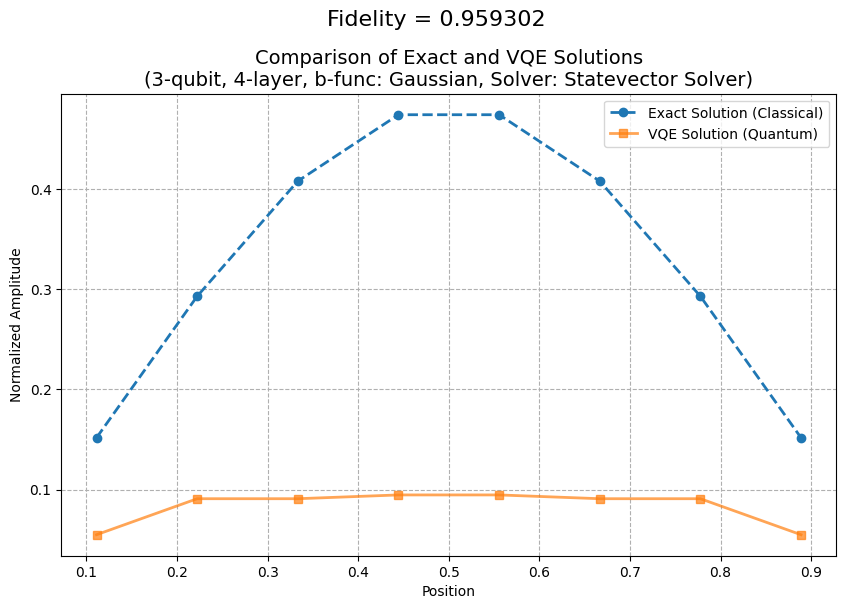